In [12]:
import pandas as pd
from biom.util import biom_open
from biom import load_table
from gneiss.util import match
from deicode.preprocessing import rclr
from deicode.optspace import OptSpace
import seaborn as sns
import pandas as pd
import numpy as np
from skbio.stats.composition import clr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

%matplotlib inline

Here we will look at a breaking case of a gradient dataset. An example real world dataset is the infant development dataset. This study summary and data can be found [here](https://qiita.ucsd.edu/study/description/101).

In [204]:
in_biom='data/Infants/table.biom'
in_meta='data/Infants/metadata.txt'

table = load_table(in_biom)
table = table.to_dataframe().T
table = table[table.T.sum()>500].fillna(0)

meta = pd.read_table(in_meta,index_col=0)

table,meta = match(table,meta.drop('101.Mother'))
table.shape


(59, 676)

This dataset is high-rank meaning it forms a gradient between the samples and features.

In [205]:
from gneiss.cluster._pba import correlation_linkage, gradient_linkage
from gneiss.sort import gradient_sort, mean_niche_estimator


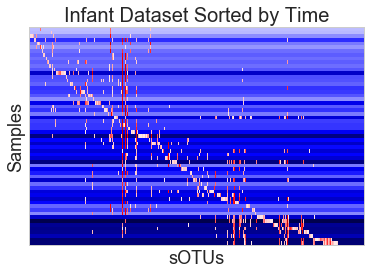

In [232]:
table_grad = table.copy()
table_grad.sort_index()
c = pd.Series(meta['age'])
table, c = match(table_grad, c)
t = gradient_linkage(table_grad+1, c, method='average')
mean_g = mean_niche_estimator(table_grad, c)
mean_g = pd.Series(mean_g, index=table_grad.columns)
mean_g = mean_g.sort_values()

# plot the gradient
table_grad = table_grad.reindex(index=meta.sort_values('age').index,columns=mean_g.index)
plt.imshow(clr(table_grad+1),aspect='auto',norm=MidpointNormalize(midpoint=0.), cmap='seismic')
plt.title('Infant Dataset Sorted by Time',fontsize=20)
plt.ylabel('Samples',fontsize=18)
plt.xlabel('sOTUs',fontsize=18)
plt.xticks([])
plt.yticks([])
plt.show()



This breaks the low-rank assumptions of RPCA and cause a poor or misleading outcome, especially at low sample counts!

In [233]:
#PCoA and PERMANOVA
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
from scipy.spatial import distance
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform


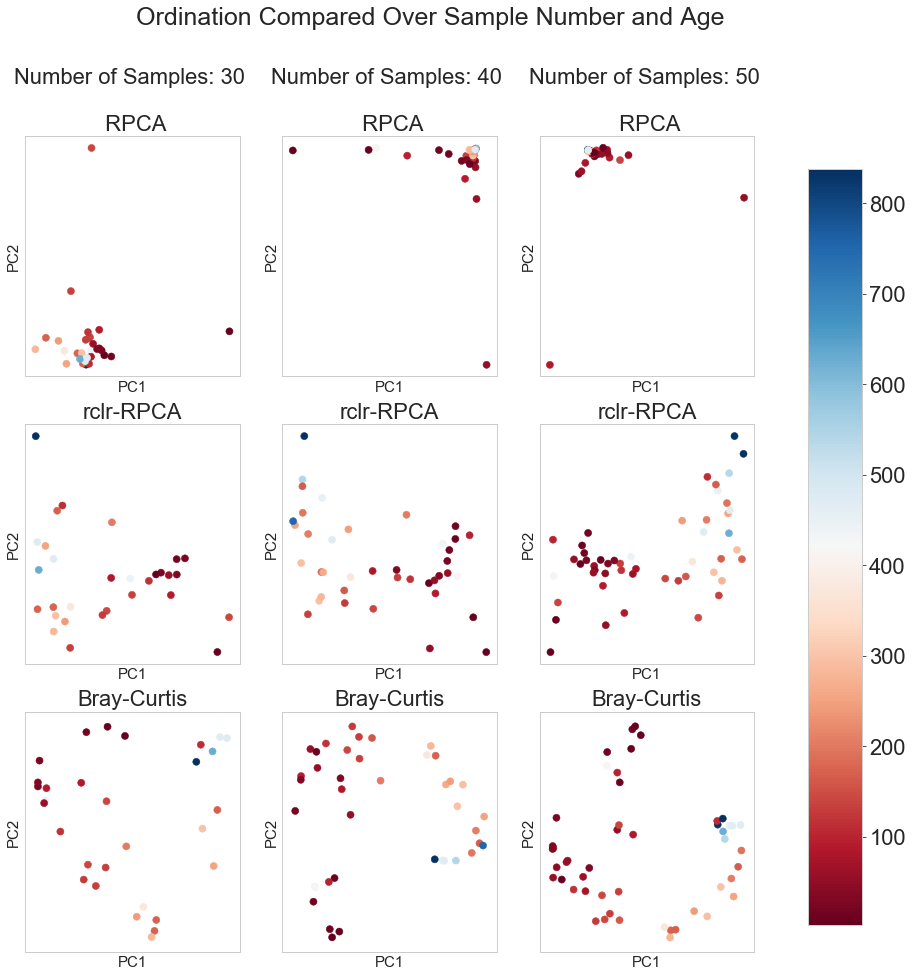

In [240]:
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

fig,axn = plt.subplots(3,3,figsize=(15,15))

axn = axn.T.flatten()
count_ = 0
# run over subsamples (30,N_max)
for sub_ in np.arange(30,table_grad.shape[0],10):
    #RPCA on random
    table_grad_tmp = table_grad.sample(n=sub_)
    table_grad_shape_rclr = rclr().fit_transform(table_grad_tmp)
    U,s,V = OptSpace().fit_transform(table_grad_tmp)
    U_clr,s_clr,V_clr = OptSpace().fit_transform(table_grad_shape_rclr)
    
    U = pd.DataFrame(U,index=table_grad_tmp.index,
                    columns=['PC1','PC2'])
        
    U_clr = pd.DataFrame(U_clr,index=table_grad_tmp.index,
                        columns=['PC1','PC2'])
    
    #no clr 
    ax = axn[count_]
    count_+=1
    U,meta_tmp = match(U,meta)
    ax.set_title('Number of Samples: '+str(sub_)+' \n\n RPCA',fontsize=22)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2',fontsize=15)
    ax.set_xlabel('PC1',fontsize=15)
    ax.scatter(U['PC1'], U['PC2'], 
               c=meta_tmp['age'], s=50, 
               cmap="RdBu")
    
    #with clr 
    ax = axn[count_]
    count_+=1
    U_clr,meta_tmp = match(U_clr,meta)
    ax.set_title('rclr-RPCA',fontsize=22)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2',fontsize=15)
    ax.set_xlabel('PC1',fontsize=15)
    ax.scatter(U_clr['PC1'], U_clr['PC2'], 
               c=meta_tmp['age'], s=50, 
               cmap="RdBu")
    
    #bray-curtis
    ax = axn[count_]
    count_+=1
    bray_ = pcoa(DistanceMatrix(pdist(table_grad_tmp
                                      ,'braycurtis'))).samples
    bray_.index = table_grad_tmp.index
    bray_,meta_tmp = match(bray_,meta)
    ax.set_title('Bray-Curtis',fontsize=22)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2',fontsize=15)
    ax.set_xlabel('PC1',fontsize=15)
    points = ax.scatter(bray_['PC1'], bray_['PC2'], 
               c=meta_tmp['age'], s=50, 
               cmap="RdBu")
    
plt.suptitle('Ordination Compared Over Sample Number and Age',fontsize=25,y=1)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(points, cax=cbar_ax)
fig.savefig('figures/supp_fig1.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()

